In [6]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM , Dense, Dropout , BatchNormalization, Input, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Constant
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
import os

In [8]:
# Load the dataset
file_path = r'C:\Users\Rushi\Desktop\News_dataset\News_Category_Dataset_v3.json' # add path to json file
df = pd.read_json(file_path, lines=True)
df.drop(columns=['link','authors', 'short_description'], inplace=True)
df

,headline,category,date
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,2022-09-23
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,2022-09-23
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,2022-09-23
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,2022-09-23
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,2022-09-22
...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,2012-01-28
209523,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,2012-01-28
209524,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,2012-01-28
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,2012-01-28


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   headline  209527 non-null  object        
 1   category  209527 non-null  object        
 2   date      209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 4.8+ MB


In [4]:
# Removing unwanted category
words_to_remove = ['WELLNESS', 'PARENTING', 'QUEER VOICES', 'COMEDY', 'BLACK VOICES', 'PARENTS', 
                   'THE WORLDPOST', 'WEDDINGS', 'WOMEN', 'IMPACT', 'DIVORCE', 'WEIRD NEWS', 'CRIME'
                  'GREEN', 'WORLDPOST', 'RELIGION', 'TASTE', 'FIFTY', 'GOOD NEWS', 'U.S. NEWS', 'GREEN',
                  'COLLEGE', 'LATINO VOICES', 'EDUCATION', 'ARTS', 'CULTURE & ARTS', 'ARTS & CULTURE']

for word in words_to_remove:
    df = df[~df['category'].str.contains(word)]

df = df.reset_index(drop=True)
df['category'] = df['category'].replace({'WORLD NEWS': 'GLOBAL', 'STYLE & BEAUTY': 'GLAMOUR', 'FOOD & DRINK': 'CONSUMABLES',
                                         'STYLE': 'LIFESTYLE', 'HEALTHY LIVING':'LIFESTYLE', 'HOME & LIVING':'LIFESTYLE'})
df

,headline,category,date
0,Puerto Ricans Desperate For Water After Hurric...,GLOBAL,2022-09-22
1,Biden At UN To Call Russian War An Affront To ...,GLOBAL,2022-09-21
2,World Cup Captains Want To Wear Rainbow Armban...,GLOBAL,2022-09-21
3,Man Sets Himself On Fire In Apparent Protest O...,GLOBAL,2022-09-21
4,Fiona Threatens To Become Category 4 Storm Hea...,GLOBAL,2022-09-21
...,...,...,...
120665,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,2012-01-28
120666,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,2012-01-28
120667,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,2012-01-28
120668,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,2012-01-28


In [5]:
df['category'].value_counts()

category
POLITICS         35602
ENTERTAINMENT    17362
LIFESTYLE        13268
TRAVEL            9900
GLAMOUR           9814
CONSUMABLES       6340
BUSINESS          5992
SPORTS            5077
CRIME             3562
GLOBAL            3299
MEDIA             2944
SCIENCE           2206
TECH              2104
MONEY             1756
ENVIRONMENT       1444
Name: count, dtype: int64

In [6]:
df['category'].unique()

array(['GLOBAL', 'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS',
       'ENVIRONMENT', 'CRIME', 'SCIENCE', 'BUSINESS', 'GLAMOUR',
       'CONSUMABLES', 'MEDIA', 'LIFESTYLE', 'TRAVEL', 'MONEY'],
      dtype=object)

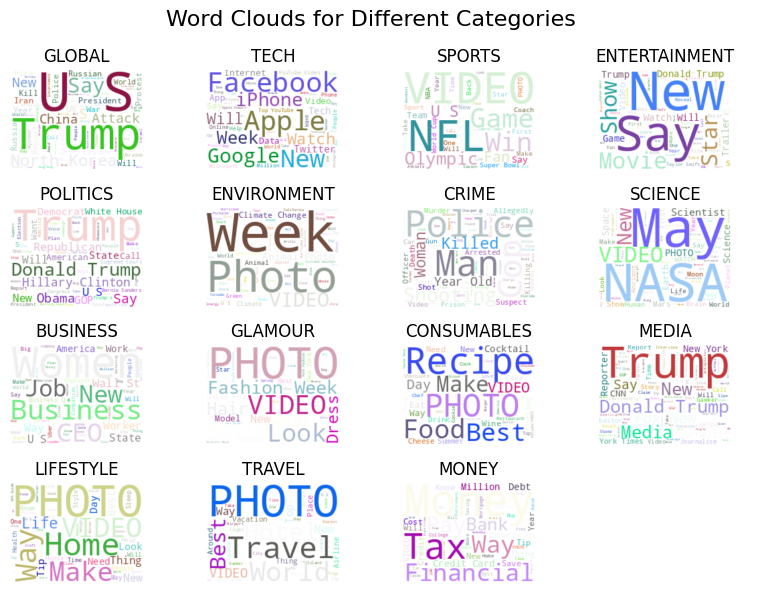

In [7]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * random.random())
    s = int(100.0 * random.random())
    l = int(70.0 * random.random()) + 30  # Increase lightness for brighter colors (30-100 range)
    return "hsl({}, {}%, {}%)".format(h, s, l)

# Create an interactive word cloud for each category with light theme
fig, axes = plt.subplots(4, 4, figsize=(8, 6), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
for ax, category in zip(axes.flatten(), df['category'].unique()):
    wordcloud = WordCloud(width=200, height=150, random_state=42, max_font_size=80, background_color='white',
                          color_func=random_color_func, stopwords=STOPWORDS).generate(' '.join(df[df['category']==category]['headline']))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(category, color='black')  # Set title color to black for visibility
plt.suptitle('Word Clouds for Different Categories', fontsize=16, color='black')  # Set suptitle color to black
plt.tight_layout()
plt.show()

In [ ]:
# Function to generate random color
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * random.random())
    s = int(100.0 * random.random())
    l = int(50.0 * random.random()) + 50
    return "hsl({}, {}%, {}%)".format(h, s, l)

# Set dark background
plt.style.use('dark_background')

# Create an interactive word cloud for each category with dark theme
fig, axes = plt.subplots(4, 4, figsize=(10,8), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
for ax, category in zip(axes.flatten(), df['category'].unique()):
    wordcloud = WordCloud(width=400, height=300, random_state=42, max_font_size=100, background_color='black',
                          color_func=random_color_func, stopwords=STOPWORDS).generate(' '.join(df[df['category']==category]['headline']))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(category, color='white')  # Set title color to white for visibility
plt.suptitle('Word Clouds for Different Categories', fontsize=20, color='white')  # Set suptitle color to white
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


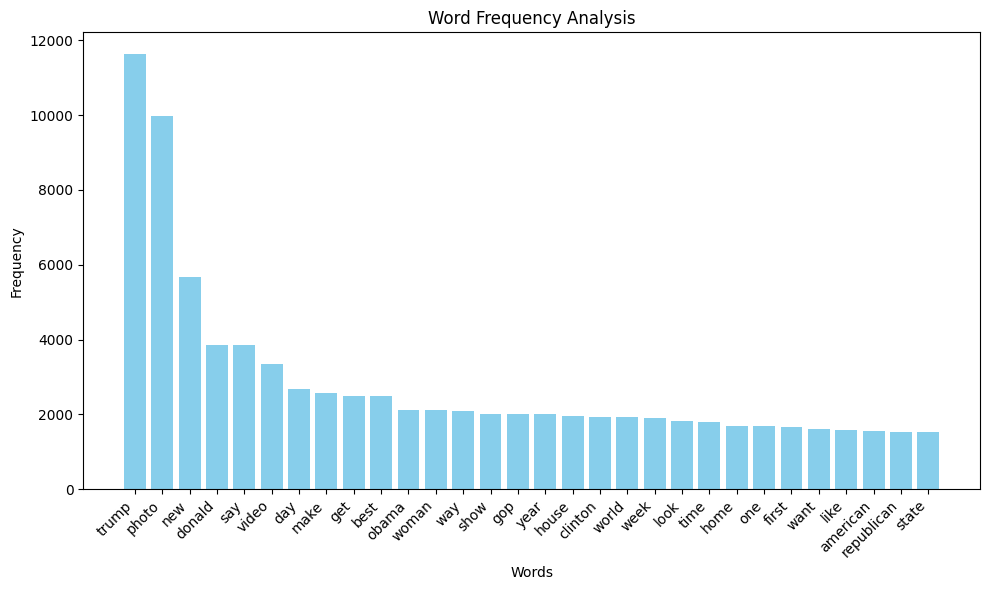

In [8]:
# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))  
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    # Lemmatization 
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['processed_headline'] = df['headline'].apply(preprocess_text)

# Word Frequency Analysis
def word_frequency_analysis(text):
    # Calculate word frequencies
    word_frequencies = nltk.FreqDist(word_tokenize(text))
    
    # Plot word frequencies
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.style.use('default')  # Use default Matplotlib style
    plt.bar(*zip(*word_frequencies.most_common(30)), color='skyblue')
    plt.gca().set_facecolor('white')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Analysis')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

word_frequency_analysis(df['processed_headline'].str.cat(sep=' '))

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_headline'], df['category'], test_size=0.2, random_state=42)

# Tokenize and pad the sequences
max_words = 5000  
max_len = 100  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)   # assigning a token id to the token(words from processed_headline)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len) # adds token-id(padding, token_id that has no value) to the start if len(sentence) < max_len
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)  # removes token-id from front if len(sentence) > max_len

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train) # encoding 15 categories to [0 to 14]
y_test_encoded = label_encoder.transform(y_test)

# Build the neural network model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=6, batch_size=128, 
                    validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
accuracy = model.evaluate(X_test_pad, y_test_encoded)[1]
print(f'Accuracy: {accuracy:.2f}')

Epoch 1/6
604/604 ━━━━━━━━━━━━━━━━━━━━ 822s 1s/step - accuracy: 0.4101 - loss: 1.9002 - val_accuracy: 0.6351 - val_loss: 1.1948
Epoch 2/6
604/604 ━━━━━━━━━━━━━━━━━━━━ 1266s 2s/step - accuracy: 0.6526 - loss: 1.1415 - val_accuracy: 0.6897 - val_loss: 1.0318
Epoch 3/6
604/604 ━━━━━━━━━━━━━━━━━━━━ 1252s 2s/step - accuracy: 0.7115 - loss: 0.9613 - val_accuracy: 0.7055 - val_loss: 0.9742
Epoch 4/6
604/604 ━━━━━━━━━━━━━━━━━━━━ 1252s 2s/step - accuracy: 0.7380 - loss: 0.8603 - val_accuracy: 0.7074 - val_loss: 0.9607
Epoch 5/6
604/604 ━━━━━━━━━━━━━━━━━━━━ 1249s 2s/step - accuracy: 0.7507 - loss: 0.8006 - val_accuracy: 0.7167 - val_loss: 0.9418
Epoch 6/6
604/604 ━━━━━━━━━━━━━━━━━━━━ 1259s 2s/step - accuracy: 0.7652 - loss: 0.7563 - val_accuracy: 0.7156 - val_loss: 0.9576
755/755 ━━━━━━━━━━━━━━━━━━━━ 256s 339ms/step - accuracy: 0.7198 - loss: 0.9255
Accuracy: 0.72


In [10]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

755/755 ━━━━━━━━━━━━━━━━━━━━ 77s 102ms/step - accuracy: 0.7198 - loss: 0.9255
Test Accuracy: 71.88%


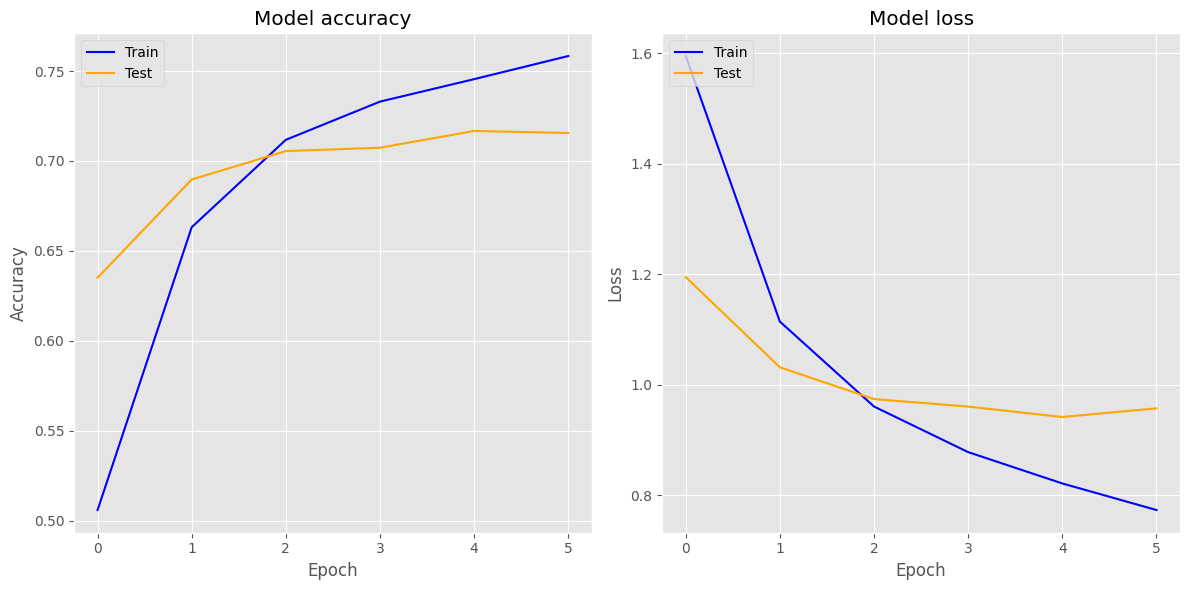

In [11]:
# Visualize training history
plt.style.use('ggplot')

# Create a figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], color='blue', label='Train')
axs[0].plot(history.history['val_accuracy'], color='orange', label='Test')
axs[0].set_title('Model accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'], color='blue', label='Train')
axs[1].plot(history.history['val_loss'], color='orange', label='Test')
axs[1].set_title('Model loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [12]:
# Saving the model for future use
model.save('news.keras') 